In [1]:
! pip install kaggle

In [7]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
! cp /content/kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:41<00:00, 83.3MB/s]
100% 2.29G/2.29G [00:41<00:00, 60.0MB/s]


In [11]:
from zipfile import ZipFile
file_name = "/content/chest-xray-pneumonia.zip"
with ZipFile(file_name , 'r')as zip:
  zip.extractall()
  print('done')

done


>### Import the necessary packages

In [12]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

>### Loading the data

In [13]:
train_dir = "/content/chest_xray/train"
test_dir = "/content/chest_xray/test"
val_dir = "/content/chest_xray/val"

>### Data Augmentation
>* Using ImageDataGenerator, to augment our images so as to create a larger dataset 

In [14]:
img_Datagen = ImageDataGenerator(
        rescale = 1/255,
        shear_range=10,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5,2.0],
        width_shift_range = 0.2,
        rotation_range=20,
        fill_mode = 'nearest'
)
val_Datagen = ImageDataGenerator(
        rescale = 1/255
)

In [15]:
train = img_Datagen.flow_from_directory(train_dir,
                                       batch_size=32,
                                       class_mode='binary',

                                       )

validation = val_Datagen.flow_from_directory(val_dir,
                                              batch_size=2,
                                              class_mode='binary',

                                            )

test = val_Datagen.flow_from_directory(test_dir,
                                       batch_size=2,
                                       class_mode='binary',

                                      )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [16]:
img, label = next(train)

>###    Defining the model
>*    Using pre-trainied ResNet50V2 model.


> 1.   include_top: whether to include the fully-connected layer at the top of the network.
2.   weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.
3. nput_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3) (with 'channels_last' data format) or (3, 224, 224) (with 'channels_first' data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (200, 200, 3) would be one valid value.




>*    Freezing all the layers of model of train.
>*    Using Adam as optimizer and binary_crossentropy as loss function.


In [17]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

94683136/94668760 [==============================] - 3s 0us/step


In [18]:
model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

In [19]:
# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [20]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [21]:
history = model2.fit(train,epochs=30, 
                    validation_data=validation,
                     steps_per_epoch=100,
                    
                    batch_size=32)

Epoch 1/30
100/100 [==============================] - 118s 1s/step - loss: 0.3020 - accuracy: 0.8681 - val_loss: 0.2048 - val_accuracy: 0.9375
Epoch 2/30
100/100 [==============================] - 95s 947ms/step - loss: 0.2129 - accuracy: 0.9097 - val_loss: 0.2751 - val_accuracy: 0.8750
Epoch 3/30
100/100 [==============================] - 93s 932ms/step - loss: 0.1981 - accuracy: 0.9162 - val_loss: 0.1852 - val_accuracy: 0.8750
Epoch 4/30
100/100 [==============================] - 94s 940ms/step - loss: 0.1935 - accuracy: 0.9237 - val_loss: 0.2150 - val_accuracy: 0.9375
Epoch 5/30
100/100 [==============================] - 95s 947ms/step - loss: 0.1596 - accuracy: 0.9375 - val_loss: 0.1851 - val_accuracy: 0.9375
Epoch 6/30
100/100 [==============================] - 94s 940ms/step - loss: 0.1886 - accuracy: 0.9237 - val_loss: 0.2070 - val_accuracy: 0.8750
Epoch 7/30
100/100 [==============================] - 93s 929ms/step - loss: 0.1658 - accuracy: 0.9316 - val_loss: 0.1580 - val_accu

>### Evaluating ResNet50V2

In [22]:
score=model2.evaluate(train)

163/163 [==============================] - 148s 906ms/step - loss: 0.1189 - accuracy: 0.9540


In [23]:
# train data
print("Train Accuracy:",score[1])

Train Accuracy: 0.953987717628479


In [24]:
score=model2.evaluate(test)
# train data
print("Test Accuracy:",score[1])

312/312 [==============================] - 12s 39ms/step - loss: 0.1870 - accuracy: 0.9295
Test Accuracy: 0.9294871687889099


Text(0.5, 1.0, 'Accuracy Evolution')

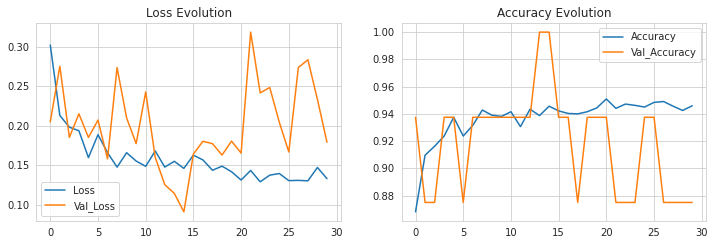

In [25]:
plt.figure(figsize=(12, 8))
plt.title('EVALUATION OF VGG19')

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')